In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.model_selection import cross_val_score
import seaborn as sns


In [4]:
#importing datasets
job_profile = pd.read_csv("/Users/vennilaannamalai/Downloads/City_of_Baltimore_-_Compensation_Grade_-_with_Job_Profile.csv", header = None)
job_profile_summary = pd.read_csv("/Users/vennilaannamalai/Downloads/City_of_Baltimore_-_Job_Profile_Summary.csv")
positions = pd.read_csv("/Users/vennilaannamalai/Downloads/Positions as of 2023-07-01.csv")
all_years_vacancies = pd.read_csv("/Users/vennilaannamalai/Downloads/all_years_vacancies.csv")
vacant_funded = pd.read_csv("/Users/vennilaannamalai/Downloads/Vacancies by PIN FY19-FY23.csv")
vacancy_summary = pd.read_csv("/Users/vennilaannamalai/Downloads/vacancy_summary.csv")
unfunded = pd.read_csv("/Users/vennilaannamalai/Downloads/unfunded.csv")

In [5]:
#Cleaning up job_profile data frame
jp_columns = ["Compensation Grade", "Reference ID", "Salary Admin Plan", "Inactive", "Number of Segments", "Base Pay Elements", "Pay Range Frequency", "Pay Minimum", "Pay Midpoint", "Pay Max", "Compensation Steps", "Step Name", "Amount", "Sequence", "Interval", "Period"]
job_profile.columns = jp_columns
job_profile = job_profile.drop([0, 1]).reset_index(drop=True)

In [6]:
#Cleaning data and merging dataframes together
vacancy_positions_funded = positions.merge(vacant_funded, on = "Classification ID")
all_data = vacancy_positions_funded.merge(vacancy_summary, on = "Service ID")
all_data.drop(['Classification Name_x', "Agency Name_x", "Service Name_x", 'Status 2023-07-01'], axis = 1)

#getting rid of duplicated column names and getting rid of _x and _y
all_data = all_data.loc[:, ~all_data.columns.duplicated()]
all_data.rename(columns=lambda x: x.replace('_y', ''), inplace=True)
all_data.rename(columns=lambda x: x.replace('_x', ''), inplace=True)

#Filtering out any positions that are not funded

data = all_data[all_data["FY24 Adopted Status"] == "Funded"]
data = data.drop(['Worker', 'Budgeted OPC', 'Actual Annual Rate', 'Status 2023-07-01', '2023-07-01 Vacant - OPC'], axis = 1)
data.columns


Index(['Position ID', 'FY24 Adopted Status', 'Workday Fund ID',
       'Classification ID', 'Classification Name', 'Union ID', 'Union Name',
       'Agency ID', 'Agency Name', 'Service ID', 'Service Name', 'Activity ID',
       'Activity Name', 'Fund ID', 'Fund Name', 'Detailed Fund ID',
       'Detailed Fund Name', 'Special Indicator ID', 'Special Indicator Name',
       'Budgeted Salary', 'Total Budgeted Cost', 'Position Grade', 'Time Type',
       'Position Type', 'Position Job Code', 'Position Job Profile',
       'Workday Agency', 'Workday Cost Center', 'Workday Fund',
       'Classification Name', 'Avg Months Vacant', 'Avg Pct Vacant', '# PINs',
       'Range Minimum', 'Range Maximum', 'Agency Name', 'Service Name',
       'Funded General Fund Positions', '2023-07-01 Vacant - Positions',
       '2023-07-01 Vacant - Salary', '2023-07-01 Vacant - Total Cost'],
      dtype='object')

In [7]:
#generating summary statistics grouped by position grade
position_grade_distribution = data.groupby(['Position Grade']).agg(['mean', 'median', 'std'])
position_grade_distribution = position_grade_distribution[['Avg Months Vacant', '2023-07-01 Vacant - Positions']]
position_grade_distribution

/var/folders/tn/sxbtn1vd4wn36lp4dl01fsdm0000gp/T/ipykernel_10196/163168086.py:2: FutureWarning: ['FY24 Adopted Status', 'Classification Name', 'Union ID', 'Union Name', 'Agency Name', 'Service Name', 'Activity Name', 'Fund Name', 'Detailed Fund Name', 'Special Indicator Name', 'Budgeted Salary', 'Total Budgeted Cost', 'Time Type', 'Position Type', 'Position Job Code', 'Position Job Profile', 'Workday Agency', 'Workday Cost Center', 'Workday Fund', 'Classification Name', 'Avg Pct Vacant', 'Range Minimum', 'Range Maximum', 'Agency Name', 'Service Name', '2023-07-01 Vacant - Salary', '2023-07-01 Vacant - Total Cost'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  position_grade_distribution = data.groupby(['Position Grade']).agg(['mean', 'median', 'std'])


Avg Months Vacant                   \
                            mean median       std   
Position Grade                                      
030                    39.000000   39.0  0.000000   
040                     2.000000    2.0  0.000000   
041                     3.384615    3.0  0.506370   
042                    30.000000   30.0  0.000000   
047                    13.000000   13.0       NaN   
...                          ...    ...       ...   
992                     4.666667    5.0  1.154701   
993                     8.750000    8.0  1.500000   
994                    18.000000   18.0       NaN   
995                     8.000000    8.0       NaN   
99P                     6.000000    6.0       NaN   

               2023-07-01 Vacant - Positions                   
                                        mean median       std  
Position Grade                                                 
030                               151.000000  151.0  0.000000  
040                                14.285714   16.0  4.535574  
041                                13.153846   16.0  5.413658  
042                                16.000000   16.0  0.000000  
047                                16.000000   16.0       NaN  
...                                      ...    ...       ...  
992                                 5.750000    4.5  4.371914  
993                                17.000000   17.0  0.000000  
994                                17.000000   17.0       NaN  
995                                17.000000   17.0       NaN  
99P                                48.000000   48.0       NaN  

[172 rows x 6 columns]

In [8]:
#general summary statistics on these three columns
stats = data.describe(include='all')
stats = stats[['Total Budgeted Cost', 'Avg Months Vacant', '2023-07-01 Vacant - Positions']]
stats

,Total Budgeted Cost,Avg Months Vacant,2023-07-01 Vacant - Positions
count,11619,11619.000000,11619.000000
unique,5629,NaN,NaN
top,"83,252",NaN,NaN
freq,99,NaN,NaN
mean,NaN,8.587228,82.035717
std,NaN,6.242464,107.264315
min,NaN,0.000000,1.000000
25%,NaN,4.000000,10.000000
50%,NaN,9.000000,48.000000
75%,NaN,11.000000,81.000000


In [9]:
classification_distribution = data.groupby(['Classification ID']).agg(['mean', 'median', 'std'])
classification_distribution = classification_distribution[['Avg Months Vacant', '2023-07-01 Vacant - Positions']]
classification_distribution

/var/folders/tn/sxbtn1vd4wn36lp4dl01fsdm0000gp/T/ipykernel_10196/3000947198.py:1: FutureWarning: ['FY24 Adopted Status', 'Classification Name', 'Union ID', 'Union Name', 'Agency Name', 'Service Name', 'Activity Name', 'Fund Name', 'Detailed Fund Name', 'Special Indicator Name', 'Budgeted Salary', 'Total Budgeted Cost', 'Position Grade', 'Time Type', 'Position Type', 'Position Job Code', 'Position Job Profile', 'Workday Agency', 'Workday Cost Center', 'Workday Fund', 'Classification Name', 'Avg Pct Vacant', 'Range Minimum', 'Range Maximum', 'Agency Name', 'Service Name', '2023-07-01 Vacant - Salary', '2023-07-01 Vacant - Total Cost'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  classification_distribution = data.groupby(['Classification ID']).agg(['mean', 'median', 'std'])


Avg Months Vacant             2023-07-01 Vacant - Positions  \
                               mean median  std                          mean   
Classification ID                                                               
10                              1.0    1.0  NaN                     17.000000   
21                              4.0    4.0  0.0                     22.250000   
32                             10.0   10.0  NaN                     17.000000   
68                              4.0    4.0  0.0                     12.285714   
70                             14.0   14.0  NaN                      4.000000   
...                             ...    ...  ...                           ...   
84321                          15.0   15.0  0.0                      3.193548   
84323                           3.0    3.0  0.0                      3.000000   
84325                           7.0    7.0  0.0                      3.000000   
90000                          22.0   22.0  0.0                     18.961538   
99000                           8.0    8.0  0.0                     81.000000   

                                     
                  median        std  
Classification ID                    
10                  17.0        NaN  
21                  17.0  21.685248  
32                  17.0        NaN  
68                  16.0   6.343350  
70                   4.0        NaN  
...                  ...        ...  
84321                3.0   0.749193  
84323                3.0   0.000000  
84325                3.0   0.000000  
90000               10.0  24.080666  
99000               81.0   0.000000  

[839 rows x 6 columns]

In [10]:
#saving summary stats and cleaned data table as excel files to my laptop
position_grade_distribution.to_excel("/Users/vennilaannamalai/Downloads/Months\position_grade_stats.xlsx")
classification_distribution.to_excel("/Users/vennilaannamalai/Downloads/Months\classification_distribution_stats.xlsx")
stats.to_excel("/Users/vennilaannamalai/Downloads/Months\general_stats.xlsx")
data.to_excel("/Users/vennilaannamalai/Downloads/Months\data.xlsx", index = False)


In [11]:
'''def create_histogram(data_frame, column_name, bins=100, color='skyblue', edgecolor='black'):

    if column_name not in data_frame.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return
    
    plt.hist(data_frame[column_name], bins=bins, color=color, edgecolor=edgecolor)

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')

    plt.show()

continuous_variables = ["Avg Months Vacant", "2023-07-01 Vacant - Positions", 'Funded General Fund Positions']
for i in range(len(continuous_variables)):
    create_histogram(data, continuous_variables[i])'''

'def create_histogram(data_frame, column_name, bins=100, color=\'skyblue\', edgecolor=\'black\'):\n\n    if column_name not in data_frame.columns:\n        print(f"Error: Column \'{column_name}\' not found in the DataFrame.")\n        return\n    \n    plt.hist(data_frame[column_name], bins=bins, color=color, edgecolor=edgecolor)\n\n    plt.xlabel(column_name)\n    plt.ylabel(\'Frequency\')\n    plt.title(f\'Histogram of {column_name}\')\n\n    plt.show()\n\ncontinuous_variables = ["Avg Months Vacant", "2023-07-01 Vacant - Positions", \'Funded General Fund Positions\']\nfor i in range(len(continuous_variables)):\n    create_histogram(data, continuous_variables[i])'

In [12]:
#checking for any strong correlations to brainstorm what to do for future analysis
cleaned_data = data[["Classification ID", "Activity ID", "Budgeted Salary", "Total Budgeted Cost", "Position Grade"]]
correlation_matrix = cleaned_data .corr()
correlation_matrix

/var/folders/tn/sxbtn1vd4wn36lp4dl01fsdm0000gp/T/ipykernel_10196/647372411.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cleaned_data .corr()


,Classification ID,Activity ID
Classification ID,1.000000,-0.057588
Activity ID,-0.057588,1.000000


Maxing out salaries

In [13]:
data['Budgeted Salary'] = data['Budgeted Salary'].replace({',': ''}, regex=True).astype(int)
data['Total Budgeted Cost'] = data['Total Budgeted Cost'].replace({',': ''}, regex=True).astype(int)

X = data[['Activity ID', 'Position Grade', 'Avg Months Vacant']]
Y = data[["Budgeted Salary"]]


def budget_constraint(salary, *args):
    total_budgeted_cost = args[0]
    return salary - total_budgeted_cost


def optimize(salary, *args):
    actual_salary, total_budgeted_cost = args
    predicted_salary = salary
    return np.sum(np.abs(predicted_salary - actual_salary))


optimized_salaries = {}


for position_grade in data['Position Grade'].unique():
    
    X_grade = X[data['Position Grade'] == position_grade]
    Y_grade = Y[data['Position Grade'] == position_grade]
    total_budgeted_cost_grade = data.loc[data['Position Grade'] == position_grade, 'Total Budgeted Cost']

    
    if not total_budgeted_cost_grade.empty:
        total_budgeted_cost_grade = total_budgeted_cost_grade.iloc[0]

        initial_guess = Y_grade.mean()

        constraint = {'type': 'ineq', 'fun': budget_constraint, 'args': (total_budgeted_cost_grade,)}

        result = minimize(optimize, initial_guess, args=(Y_grade, total_budgeted_cost_grade), constraints=constraint)

        optimized_salary = result.x[0]

        optimized_salaries[position_grade] = optimized_salary
    else:
        print(f"No valid data for Position Grade {position_grade}")

#print("Optimized Salaries:")
#for position_grade, optimized_salary in optimized_salaries.items():
    #print(f"Position Grade {position_grade}: {optimized_salary}")
pgs_max = []
position_grade_salaries = pd.DataFrame()

for position_grade, optimized_salary in optimized_salaries.items():
    optimized_salary = optimized_salary.round()
    pgs_max.append(f"Position Grade {position_grade}: {optimized_salary}")
position_grade_salaries["Optimized Salaries"] = pgs_max
position_grade_salaries.to_excel("/Users/vennilaannamalai/Downloads/position_grade_salaries_max.xlsx")

No valid data for Position Grade nan


In [14]:
data['Budgeted Salary'] = data['Budgeted Salary'].replace({',': ''}, regex=True).astype(int)
data['Range Minimum'] = data['Range Minimum'].replace({',': ''}, regex=True).fillna(0).astype(int)
data['Range Maximum'] = data['Range Maximum'].replace({',': ''}, regex=True).fillna(0).astype(int)

X = data[['Activity ID', 'Position Grade', 'Avg Months Vacant']]
Y = data[["Budgeted Salary"]]


def optimize_and_normalize(salaries, min_salary, max_salary):
    normalized_salaries = np.clip(salaries, min_salary, max_salary)
    return np.sum(np.abs(normalized_salaries - salaries))


normalized_salaries_list = []
just_salaries = []

for position_grade in data['Position Grade'].unique():
    
    Y_grade = Y[data['Position Grade'] == position_grade]

    if not Y_grade.empty:
        min_salary_grade = data.loc[data['Position Grade'] == position_grade, 'Range Minimum'].iloc[0]  
        max_salary_grade = data.loc[data['Position Grade'] == position_grade, 'Range Maximum'].iloc[0]  

        min_salary_grade = float(min_salary_grade)
        max_salary_grade = float(max_salary_grade)

        initial_guess = Y_grade.mean()

        result = minimize(optimize_and_normalize, initial_guess, args=(min_salary_grade, max_salary_grade))

        normalized_salary = np.clip(result.x[0], min_salary_grade, max_salary_grade)
        normalized_salaries_list.append(f"Position Grade {position_grade}: {normalized_salary:.2f}")
        just_salaries.append(normalized_salary)

    else:
        print(f"No valid data for Position Grade {position_grade}")

No valid data for Position Grade nan


In [15]:
og_budgeted_salary = data.groupby("Position Grade")["Budgeted Salary"].agg(np.mean)
len(og_budgeted_salary) == len(normalized_salaries_list)

True

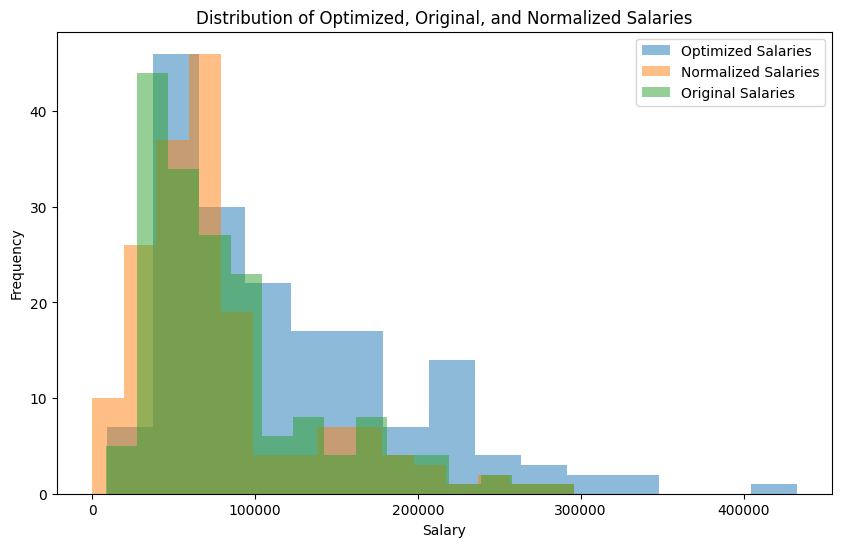

In [16]:
optimized_salaries_values = [float(s.split(":")[1]) for s in pgs_max]
normalized_salaries_values = [float(s.split(":")[1]) for s in normalized_salaries_list]
#og_budgeted_salary_values = [float(s.split(":")[1]) for s in og_budgeted_salary]

plt.figure(figsize=(10, 6))

plt.hist(optimized_salaries_values, bins=15, alpha=0.5, label='Optimized Salaries')
plt.hist(normalized_salaries_values, bins=15, alpha=0.5, label='Normalized Salaries')
plt.hist(og_budgeted_salary, bins=15, alpha=0.5, label='Original Salaries')

plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Optimized, Original, and Normalized Salaries')
plt.legend()

plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [17]:
data['Budgeted Salary'] = data['Budgeted Salary'].replace({',': ''}, regex=True).astype(int)
data['Total Budgeted Cost'] = data['Total Budgeted Cost'].replace({',': ''}, regex=True).astype(int)

X = data[['Activity ID', 'Classification ID']]

optimized_salaries_c = {}


for classification in data['Classification ID'].unique():
    
    X_grade = X[data['Classification ID'] == classification]
    Y_grade = Y[data['Classification ID'] == classification]
    total_budgeted_cost_grade = data.loc[data['Classification ID'] == classification, 'Total Budgeted Cost']

    
    if not total_budgeted_cost_grade.empty:
        total_budgeted_cost_grade = total_budgeted_cost_grade.iloc[0]

        initial_guess = Y_grade.mean()

        constraint = {'type': 'ineq', 'fun': budget_constraint, 'args': (total_budgeted_cost_grade,)}

        result = minimize(optimize, initial_guess, args=(Y_grade, total_budgeted_cost_grade), constraints=constraint)

        optimized_salary = result.x[0]

        optimized_salaries_c[classification] = optimized_salary
    else:
        print(f"No valid data for Position Grade {position_grade}")

classification_list = []
classification_salaries = pd.DataFrame()

for classification, optimized_salary in optimized_salaries_c.items():
    optimized_salary = optimized_salary.round()
    classification_list.append(f"Classification ID {classification}: {optimized_salary}")
classification_salaries["Optimized Salaries"] = classification_list
classification_salaries.to_excel("/Users/vennilaannamalai/Downloads/classification_salaries.xlsx")

In [18]:
og_budgeted_salary_df = og_budgeted_salary.reset_index()
og_budgeted_salary_df["Position Grade"] = og_budgeted_salary_df["Position Grade"].astype(str)
og_budgeted_salary_df = og_budgeted_salary_df.sort_values("Position Grade")
og_budgeted_salary_df

,Position Grade,Budgeted Salary
0,030,54281.000000
1,040,48609.000000
2,041,49813.846154
3,042,51630.750000
4,047,78955.000000
...,...,...
167,992,219944.750000
168,993,214095.000000
169,994,192890.000000
170,995,267903.000000


In [19]:
salary_data = {
    'Position Grade': [(s.split(":")[0]) for s in pgs_max],
    'Optimized Salaries': [float(s.split(":")[1]) for s in pgs_max],
    'Normalized Salaries': [float(s.split(":")[1]) for s in normalized_salaries_list]
    
}

salaries_df = pd.DataFrame(salary_data)
salaries_df['Position Grade'] = salaries_df['Position Grade'].str.extract(r'(\d+)')
salaries_df['Position Grade'] = salaries_df['Position Grade'].astype(str)


#"Original Salaries" : og_budgeted_salary_df["Budgeted Salary"].round(),
   # "OG pg" : og_budgeted_salary_df["Position Grade"]

salaries_df = salaries_df.sort_values("Position Grade")
salaries_df = salaries_df.reset_index()
salaries_df = salaries_df[["Position Grade", "Optimized Salaries", "Normalized Salaries"]]

In [20]:
salaries_df["Original Salary"] = og_budgeted_salary_df["Budgeted Salary"].round()

salaries_df

,Position Grade,Optimized Salaries,Normalized Salaries,Original Salary
0,030,66281.0,54281.00,54281.0
1,040,53565.0,48609.00,48609.0
2,041,56913.0,49813.85,49814.0
3,042,85561.0,51630.75,51631.0
4,047,85186.0,78955.00,78955.0
...,...,...,...,...
167,991,194658.0,171566.00,219945.0
168,992,310453.0,219944.75,214095.0
169,993,254854.0,192250.00,192890.0
170,994,232300.0,192890.00,267903.0


In [21]:
salaries_df.describe()

,Optimized Salaries,Normalized Salaries,Original Salary
count,172.000000,172.000000,172.000000
mean,118096.720930,78397.627965,83706.627907
std,75887.108022,54513.418582,54838.147132
min,8976.000000,0.000000,8312.000000
25%,57236.250000,44304.530000,44591.500000
50%,95396.500000,65023.930000,68682.500000
75%,161837.500000,90098.247500,97055.000000
max,432645.000000,296167.000000,296167.000000


In [22]:
otc = sum(salaries_df["Optimized Salaries"])
ntc = sum(salaries_df["Normalized Salaries"])
ogtc = sum(salaries_df["Original Salary"])

print("Total Cost Maximized Salaries:", otc,
      "Total Cost Normalized Salaries:", ntc,
      "Total Cost Original Salaries:", ogtc)

Total Cost Maximized Salaries: 20312636.0 Total Cost Normalized Salaries: 13484392.01 Total Cost Original Salaries: 14397540.0
